# LightGlue Demo
In this notebook we match two pairs of images using LightGlue with early stopping and point pruning.

In [1]:

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint", filter_threshold=0.9).eval().to(device)

/home/rmqlife/miniconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/rmqlife/miniconda3/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Easy example
The top image shows the matches, while the bottom image shows the point pruning across layers. In this case, LightGlue prunes a few points with occlusions, but is able to stop the context aggregation after 4/9 layers.

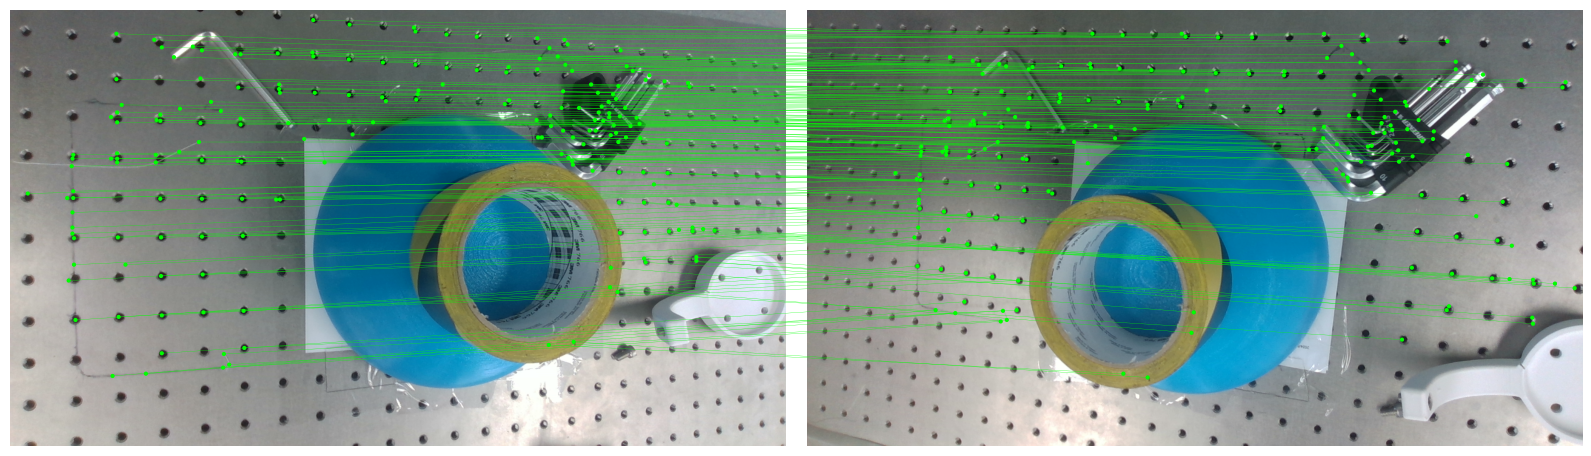

torch.Size([192, 2])
{'fx': 912.2659912109375, 'fy': 911.6720581054688, 's': 0.0, 'cx': 637.773193359375, 'cy': 375.817138671875}
(720, 1280)
x:-57.69080550007273 	 y:-150.76709409992142 	 z:382
x:-32.99281801585729 	 y:-149.76902215228327 	 z:387
x:12.50033432428559 	 y:-154.1323141080423 	 z:404
x:13.386040914013293 	 y:-151.03032148376815 	 z:404
x:-175.0111845088698 	 y:-127.83863649829432 	 z:345
x:37.13548971716982 	 y:-151.7614364756657 	 z:412
x:60.73122588827427 	 y:-152.96112221899753 	 z:419
x:110.22465842655764 	 y:-156.64714057563066 	 z:433
x:-154.63928878379153 	 y:-126.57142640994562 	 z:352
x:134.01466557602595 	 y:-158.57386092836936 	 z:441
x:136.74109277007173 	 y:-155.05485117831188 	 z:442
x:-132.89802620882952 	 y:-124.70950372016561 	 z:360
x:-150.4733397624578 	 y:-122.24271447063585 	 z:354
x:121.09992301910687 	 y:-150.76902436158664 	 z:438
x:-126.9786999903523 	 y:-122.34023071152623 	 z:360
x:184.55957522283046 	 y:-154.9642922345999 	 z:456
x:-58.22184975

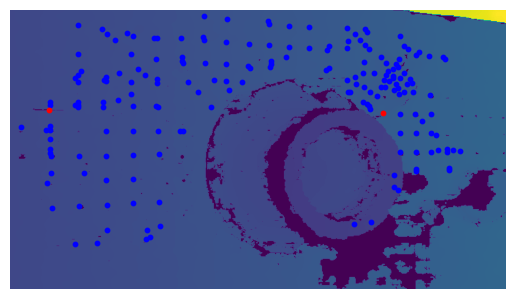

x:-77.32948665265319 	 y:-156.7412847500826 	 z:423
x:-53.377438269098064 	 y:-153.14580016449267 	 z:417
x:-8.778298640637589 	 y:-150.07144284582375 	 z:405
x:-5.670652375937054 	 y:-147.85024940022436 	 z:405
x:-200.8280237748256 	 y:-149.46231380342624 	 z:456
x:17.594096463361552 	 y:-144.78456058462183 	 z:399
x:41.77828459058756 	 y:-142.24448057436533 	 z:392
x:89.4157630588859 	 y:-140.43722676189435 	 z:379
x:-180.33414792401143 	 y:-144.85530006858883 	 z:451
x:114.16801665345739 	 y:-137.3956694306391 	 z:373
x:117.5319184353115 	 y:-133.76298472869252 	 z:372
x:-155.76874072613066 	 y:-139.85620300418395 	 z:443
x:-174.61262981744434 	 y:-140.76541462766374 	 z:449
x:100.66064084552933 	 y:-131.07700634036595 	 z:376
x:-150.08753234689493 	 y:-137.6012066813351 	 z:442
x:165.43601520242174 	 y:-128.26341323312468 	 z:360
x:-79.37140557904739 	 y:-133.85785569700676 	 z:424
x:-102.88692907788986 	 y:-134.17674226166386 	 z:431
x:-129.29295518448853 	 y:-132.73044523823154 	

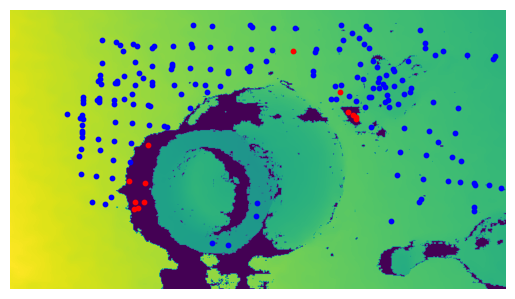

[(-57.69080550007273, -150.76709409992142, 382), (-32.99281801585729, -149.76902215228327, 387), (12.50033432428559, -154.1323141080423, 404), (13.386040914013293, -151.03032148376815, 404), (-175.0111845088698, -127.83863649829432, 345), (37.13548971716982, -151.7614364756657, 412), (60.73122588827427, -152.96112221899753, 419), (110.22465842655764, -156.64714057563066, 433), (-154.63928878379153, -126.57142640994562, 352), (134.01466557602595, -158.57386092836936, 441), (136.74109277007173, -155.05485117831188, 442), (-132.89802620882952, -124.70950372016561, 360), (-150.4733397624578, -122.24271447063585, 354), (121.09992301910687, -150.76902436158664, 438), (-126.9786999903523, -122.34023071152623, 360), (184.55957522283046, -154.9642922345999, 456), (-58.22184975465267, -127.46964400423516, 380), (-80.886439065669, -125.38107972672925, 375), (-106.44422056544627, -121.30396834403004, 364), (-103.70085356061051, -122.30372632488744, 367), (-57.53978244902542, -125.29760983501525, 3

In [2]:

import json
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import os

def replace_path(file_path, src, dst):
    directory, filename = os.path.split(file_path)  
    new_filename = filename.replace(src, dst)
    
    return os.path.join(directory, new_filename)
    
def replace_rgb_to_depth(file_path):
    return replace_path(file_path, 'rgb', 'depth')


# Factory function to create a pointcloud from an RGB-D image and a camera. Given depth value d at (u, v) image coordinate, the corresponding 3d point is:

# z = d / depth_scale
# x = (u - cx) * z / fx
# y = (v - cy) * z / fy
def project_to_3d(points, depth, intrinsics, show=True):
    if show:
        plt.imshow(depth)
    
    points_3d = list()
    
    for x,y in points:
        x = math.floor(x) 
        y = math.floor(y)
        d = depth[y][x]        
        # Plot points (x, y) on the image
        if show:
            if d>0:
                plt.scatter(x, y, color='blue', s=10)  # Adjust the size (s) as needed
            else:
                plt.scatter(x, y, color='red', s=10)

        # 3d point in milimeter
        z = d
        x = (x - intrinsics['cx']) * z / intrinsics['fx']
        y = (y - intrinsics['cy']) * z / intrinsics['fy']
        
        if show:
            print(f'x:{x} \t y:{y} \t z:{z}')
        points_3d.append((x,y,z))
        
    if show:
        plt.axis('off')  # Turn off axis labels
        plt.show()
    
    
    return points_3d
    
def load_intrinsics(json_file):
    with open(json_file, "r") as file:
        intrinsic_params = json.load(file)
    return intrinsic_params


def plot_matching(image0, image1, pts0, pts1):
    axes = viz2d.plot_images([image0, image1])
    viz2d.plot_matches(pts0, pts1, color="lime", lw=0.2)
    
def match_with_lightglue(image0, image1):
    feats0 = extractor.extract(image0.to(device))
    feats1 = extractor.extract(image1.to(device))
    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats0, feats1, matches01 = [
        rbd(x) for x in [feats0, feats1, matches01]
    ]  # remove batch dimension

    kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]
    return m_kpts0, m_kpts1


id1=1
id2=150

image_path1 = f"/home/rmqlife/Pictures/tape/rgb_{id1}.png"
image_path2 = f"/home/rmqlife/Pictures/tape/rgb_{id2}.png"


image0 = load_image(image_path1)
image1 = load_image(image_path2)

pts0, pts1 = match_with_lightglue(image0, image1)
plot_matching(image0, image1, pts0, pts1)
plt.show()

print(pts0.shape)

# Example usage:
intrinsics = load_intrinsics("/home/rmqlife/work/dino-vit-features/intrinsic_parameters.json")
print(intrinsics)

depth_path1 = replace_rgb_to_depth(image_path1)
depth_path2 = replace_rgb_to_depth(image_path2)

rgb1 = cv2.imread(image_path1)
depth1 = cv2.imread(depth_path1, cv2.IMREAD_UNCHANGED)

rgb2 = cv2.imread(image_path2)
depth2 = cv2.imread(depth_path2, cv2.IMREAD_UNCHANGED)

print(depth2.shape)
image_size = depth2.shape

pt3d1 = project_to_3d(pts0[:], depth1, intrinsics)
pt3d2 = project_to_3d(pts1[:], depth2, intrinsics)

print(pt3d1)
print(pt3d2)


In [12]:
def find_transformation(X, Y):
    """
    Inputs: X, Y: lists of 3D points
    Outputs: R - 3x3 rotation matrix, t - 3-dim translation array.
    Find transformation given two sets of correspondences between 3D points.
    """
    # Calculate centroids
    cX = np.mean(X, axis=0)
    cY = np.mean(Y, axis=0)
    # Subtract centroids to obtain centered sets of points
    Xc = X - cX
    Yc = Y - cY

    # Calculate covariance matrix
    C = np.dot(Xc.T, Yc)
    # Compute SVD
    U, S, Vt = np.linalg.svd(C)
    # Determine rotation matrix
    R = np.dot(Vt.T, U.T)
    # Determine translation vector
    t = cY - np.dot(R, cX)
    return R, t

def filter_out_zeros_points(pt3d1, pt3d2):
    new_pt3d1 = list()
    new_pt3d2 = list()
    for i in range(len(pt3d1)):
        # print(p)
        p1 = pt3d1[i]
        p2 = pt3d2[i]
        if p1[2]>1 and p2[2]>1:
            new_pt3d1.append(p1)
            new_pt3d2.append(p2)
    return new_pt3d1, new_pt3d2

def print_array(array):
    array = np.round(array, 2)
    print(np.array2string(array, separator=','))
    

from pose_util import *
R, t = find_transformation(pt3d1, pt3d2)

new_pt3d1, new_pt3d2 = filter_out_zeros_points(pt3d1, pt3d2)
R, t = find_transformation(new_pt3d1, new_pt3d2)
R, t = icp(new_pt3d2, new_pt3d1)




joints_traj = np.load('./circle_joints_traj.npy')
poses = forward_joints(joints_traj=joints_traj)

pose1 = poses[id1]
pose2 = poses[id2]
pose1_star= transform_pose(poses[id1], R, t)


print_array(pose1)
print_array(pose2)
print_array(pose1_star)

# joint_angles = [-3.14,-1.57,1.57,-1.57,-1.57,0]
# traj = plan_trajectory([pose1, pose2, pose1_star], joint_angles, num_steps=20)
# # print(traj)
# np.save('./show_traj.npy', traj)

err 258.830468775
[-0.39,-0.13, 0.49, 0.69,-0.69, 0.  , 0.22]
[-0.57,-0.19, 0.49, 0.45, 0.88, 0.  , 0.15]
[-2.4021e+02, 3.6420e+01, 8.9940e+01,-6.4000e-01, 6.4000e-01,-2.4000e-01,
 -3.5000e-01]
